# ** 0. Environment **

In [301]:
from google.colab import drive, files
# drive.mount('/content/drive')
# file_path = '/content/drive/MyDrive'

from collections import deque
import re

import pandas as pd
import os

import numpy as np



# ** 1. Data Set **

In [302]:
## Function :: Convert text 2 list
def Category_binder(perfume, col_num):

    ## 01. 대카테고리 분류
    category = []
    if '"' not in perfume[col_num]:
        category.append(perfume[col_num])
        perfume[col_num] = category
    else:
        category.append(perfume[col_num].replace('"', '').strip())
        while True:
            a_item = perfume.pop(col_num + 1)
            if '"' not in a_item:

                category.append(a_item.strip())
            else:
                category.append(a_item.replace('"', '').strip())
                break
        perfume[col_num] = category


    ## 02. 카테고리 내부 단어 전처리
    new = set()
    qq = deque(perfume[col_num])
    while qq:
        item = qq.popleft().lower()
        item = item.replace('-', '').strip()
        item = item.replace('(', '').strip()
        item = item.replace(')', '').strip()
        if 'and' in item or 'with' in item or 'of' in item:
            not_and, is_and = [], False
            temp = list(item.split())
            for j in range(len(temp)):
                if temp[j] == 'and':
                    is_and = True
                    continue
                elif temp[j] == 'with':
                    is_and = True
                    continue
                elif temp[j] == 'of':
                    is_and = True
                    continue
                not_and.append(temp[j])
            if is_and:
                for k in range(len(not_and)):
                    new.add(not_and[k])
            else:
                new.add(item)
        else:
            new.add(item)
    perfume[col_num] = new
    return perfume

## Function :: Convert list 2 txt
def TextMaker(name, catego):
    text = ''
    for tt in sorted(list(catego)):
        text += str(tt)
        text += ', '
    with open(name + '.txt', 'w') as f:
        f.write(text[:-2])

In [303]:
## 01. 파일 읽기
perfumes_dataset = open("/content/noon_perfumes_dataset.csv")
perfumes_dataset = perfumes_dataset.read()
perfumes_dataset = perfumes_dataset.replace('\n', ',').split(',')
perfumes = [] 
perfumes_tag = perfumes_dataset[:15]
perfumes_data = perfumes_dataset[15:]


## 02. 향수 별로 구분하기 ...  perfumes : [ [향수1], [향수2], ....]
idx = '1'
perfume_now = []
for data in perfumes_data:
    if data == idx:
        idx = str(int(idx) + 1)
        perfumes.append(perfume_now)
        perfume_now = []
    perfume_now.append(data)
perfumes.append(perfume_now)


## 03. 향수 내 대분류 정리
for perfume in perfumes:
    ## 03-1. old_price / new_price / ml -->> str2float
    perfume[3], perfume[4], perfume[5] = float(perfume[3]), float(perfume[4]), float(perfume[5])

    ## 03-2. scents - col no. 8
    perfume = Category_binder(perfume, 8)

    ## 03-3. base_note - col no. 9
    perfume = Category_binder(perfume, 9)

    ## 03-4. middle_note - col no. 10
    perfume = Category_binder(perfume, 10)

    ## 03-5. item_rating -->> str2float
    perfume[11] = float(perfume[11])


## 04. 향수 데이터 형식
# 0.no, 1.brand, 2.name, 3.old_price, 4.new_price, 5.mL, 6.Time_category, 7.gender, 8.Top, 9.base, 10.middle, 11.rating
all_brands = set()              # 01    150
all_names = set()               # 02    589
brand_plus_name = set()        #################
all_concentrations = set()      # 06    5
all_departments = set()         # 07    4
all_scents = set()              # 08    18
all_bases = set()               # 09    426
all_middles = set()             # 10    606

for perfume in perfumes:
    all_brands.add(perfume[1].lower())
    all_names.add(perfume[2].lower())
    brand_plus_name.add((perfume[1].lower(), perfume[2].lower()))
    all_concentrations.add(perfume[6].lower())
    all_departments.add(perfume[7].lower())
    for pt in perfume[8]:
        all_scents.add(pt.lower())
    for pb in perfume[9]:
        all_bases.add(pb.lower())
    for pm in perfume[10]:
        all_middles.add(pm.lower())

In [304]:
scents = sorted(list(all_scents))
notes = sorted(list(all_middles | all_bases))[5:]

# ** 1.05. Check

In [305]:
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Top_scents 하나 당 포함하는 notes 종류
# 0.no, 1.brand, 2.name, 3.old_price, 4.new_price, 5.mL, 6.Time_category, 7.gender, 8.Top, 9.base, 10.middle, 11.rating
scents2notes = {}
for top in all_scents:
    scents2notes[top] = [set(), set(), set()]
    for perfume in perfumes:
        if top in perfume[8]:
            for pm in perfume[10]:
                scents2notes[top][0].add(pm)
            for pb in perfume[9]:
                scents2notes[top][1].add(pb)
            scents2notes[top][2] = scents2notes[top][0] | scents2notes[top][1]
    # print(top, scents2notes[top])
    # >>> floral [{'', 'hibiscus seed', 'coriander', 'pearlescent', 'dewy english roses',.......}]

In [306]:
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Top_scent 1 개에 포함되어 있는 notes 전체
top2notes_cnt = {}
all_notes = {}
for scent in scents:
    temp = {}
    for perfume in perfumes:
        if scent in perfume[8]:
            now_all = perfume[10] | perfume[9]
            for now in now_all:
                if now == 'lilyofthevalley':
                    now = 'lily of the valley'
                if now in temp:
                    temp[now] += 1
                else:
                    temp[now] = 1
                if now in all_notes:
                    all_notes[now] += 1
                else:
                    all_notes[now] = 1
    top2notes_cnt[scent] = sorted(temp.items(), key=lambda x: x[1], reverse=True)

# for scent in scents:
#     print(scent, len(top2notes_cnt[scent]), top2notes_cnt[scent])
# >>> arabian 176 [('vanilla', 28), ('musk', 25), ('amber', 23), ('sandalwood', 22), ('tonka bean', 22), ('patchouli', 21), ....

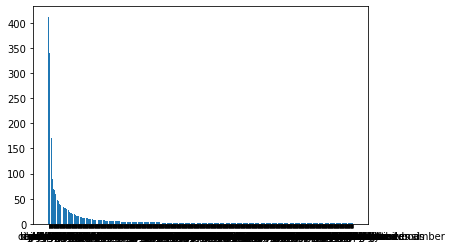

In [307]:
## 향수별로 얼마나 notes 들이 많이 사용되었는지,
## 빈도 그래프를 출력한다

all_notes = sorted(all_notes.items(), key=lambda x: x[1], reverse=True)
# all_notes
# >>> [('musk', 412), ('jasmine', 353), ('sandalwood', 349), ('amber', 340), ....

# len(all_notes)
# >>> 861


import matplotlib.pyplot as plt
import numpy as np

x_labels = []
y_labels = []
x = np.arange(len(all_notes))
for top in all_notes:
    x_labels.append(top[0])
    y_labels.append(top[1])

plt.bar(x, y_labels)
plt.xticks(x, x_labels)
plt.show()

In [308]:
## Scents 2 Notes Graph ~ sorted

# import matplotlib.pyplot as plt
# import numpy as np

# for scent in scents:
#     x = np.arange(len(puri_cutter[scent]))
#     Notes = []
#     Count = []
#     for it in puri_cutter[scent]:
#         Notes.append(it[0])
#         Count.append(it[1])

#     plt.bar(x, Count)
#     plt.xticks(x, Notes)

#     print(scent, len(puri_cutter[scent]), puri_cutter[scent])
#     plt.show()

# ** 2. Data purification

In [309]:
## 안 쓰이는 notes 들 제거하기
puri_notes = []
for top in all_notes:
    note, cnt = top
    if cnt >= 10:
        puri_notes.append(note)

In [310]:
## Sparse 2 Densee
puri_notes = set()
puri_cutter =top2notes_cnt
for top in puri_cutter:
    temp = []
    for sc, cnt in puri_cutter[top]:
        if cnt >= 3:
            puri_notes.add(sc)
            temp.append((sc, cnt))
    puri_cutter[top] = temp

# for scent in scents:
#     print(scent, len(puri_cutter[scent]), puri_cutter[scent])
# >>> arabian 51 [('vanilla', 28), ('musk', 25), ('amber', 23), ('sandalwood', 22), ...


puri_notes = sorted(list(puri_notes)[:-1])
# print(len(puri_notes))
# puri_notes
# >>> 240
# >>> ['accord', 'accords', 'african orange flower', 'agarwood', 'almond',...

In [311]:
### !!!! 실제 데이터 구성 !!! ###
## 현재 - puri_notes(240) @ scents(11)
Data_x = [[0.01] * len(puri_notes) for _ in range(len(perfumes))]
Data_y = [[0] * len(scents) for _ in range(len(perfumes))]
for i in range(len(perfumes)):
    perfume = perfumes[i]
    data_x = list(perfume[10] | perfume[9])
    data_y = list(perfume[8])[0]
    for data in data_x:
        if data not in puri_notes:
            continue
        Data_x[i][puri_notes.index(data)] = 1.00
    Data_y[i][scents.index(data_y)] = 1

In [312]:
### !!!! 실제 데이터 구성 !!! ###
x_all = np.array(Data_x)
y_all = np.array(Data_y)
# x_train, x_test = x_all[:800], x_all[801:]
# y_train, y_test = y_all[:800], y_all[801:]

# print(x_train.shape)
# print(y_train.shape)
print(x_all.shape)
print(y_all.shape)


(1003, 240)
(1003, 11)


# ** 3. Classification model **

In [313]:
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling1D

c_model = keras.Sequential()

c_model.add(Dense(128, activation='relu'))
c_model.add(Dense(64, activation='relu'))
c_model.add(Dense(11, activation='softmax'))

In [314]:
c_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [315]:
# history = c_model.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=10)
history = c_model.fit(x_all, y_all, epochs=20, batch_size=20, shuffle=True, validation_split=0.2)

Epoch 1/20
41/41 [==============================] - 1s 9ms/step - loss: 2.1966 - accuracy: 0.2756 - val_loss: 2.0536 - val_accuracy: 0.3134
Epoch 2/20
41/41 [==============================] - 0s 3ms/step - loss: 1.9091 - accuracy: 0.3554 - val_loss: 1.9371 - val_accuracy: 0.3483
Epoch 3/20
41/41 [==============================] - 0s 3ms/step - loss: 1.7473 - accuracy: 0.4514 - val_loss: 1.8448 - val_accuracy: 0.3930
Epoch 4/20
41/41 [==============================] - 0s 3ms/step - loss: 1.5823 - accuracy: 0.4825 - val_loss: 1.7920 - val_accuracy: 0.4080
Epoch 5/20
41/41 [==============================] - 0s 3ms/step - loss: 1.4381 - accuracy: 0.5574 - val_loss: 1.6920 - val_accuracy: 0.4527
Epoch 6/20
41/41 [==============================] - 0s 3ms/step - loss: 1.2911 - accuracy: 0.5973 - val_loss: 1.6895 - val_accuracy: 0.4677
Epoch 7/20
41/41 [==============================] - 0s 3ms/step - loss: 1.1566 - accuracy: 0.6272 - val_loss: 1.6014 - val_accuracy: 0.4975
Epoch 8/20
41/41 [==

In [316]:
# loss_test, acc_test = c_model.evaluate(x_test, y_test)
loss_test, acc_test = c_model.evaluate(x_all, y_all)

print(loss_test)
print(acc_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.5951 - accuracy: 0.8465
0.5950692892074585
0.8464606404304504


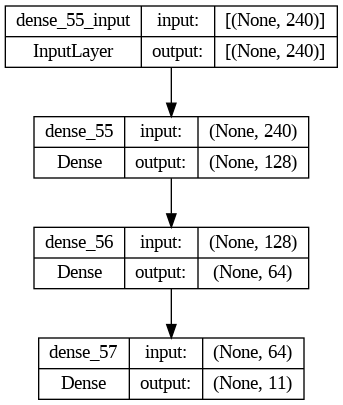

In [317]:
keras.utils.plot_model(c_model, show_shapes=True)

In [318]:
c_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 128)               30848     
                                                                 
 dense_56 (Dense)            (None, 64)                8256      
                                                                 
 dense_57 (Dense)            (None, 11)                715       
                                                                 
Total params: 39,819
Trainable params: 39,819
Non-trainable params: 0
_________________________________________________________________


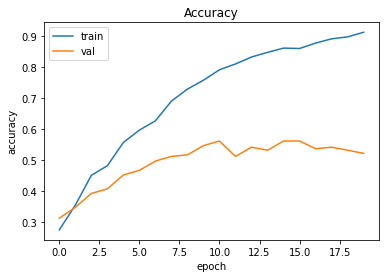

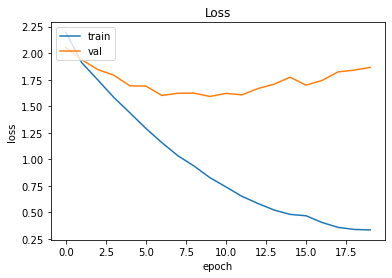

In [319]:
# 10. 학습 시각화하기
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# ** 4. Auto-Encoder model **


In [381]:
import keras
from keras import layers
input_dim = 240

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [382]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [383]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [384]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [385]:
# from keras.datasets import mnist
# import numpy as np
# (x_train, _), (x_test, _) = mnist.load_data()

In [386]:
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print(x_train.shape)
# print(x_test.shape)

In [387]:
print(x_all.shape)
print(y_all.shape)

(1003, 240)
(1003, 11)


In [388]:
history = autoencoder.fit(x_all, x_all,
                epochs=100,
                batch_size=20,
                shuffle=True,
                validation_split=0.2)

Epoch 1/100
41/41 [==============================] - 1s 10ms/step - loss: 0.6365 - accuracy: 0.0137 - val_loss: 0.5191 - val_accuracy: 0.0348
Epoch 2/100
41/41 [==============================] - 0s 7ms/step - loss: 0.3567 - accuracy: 0.0287 - val_loss: 0.2168 - val_accuracy: 0.0398
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 0.1861 - accuracy: 0.0411 - val_loss: 0.1611 - val_accuracy: 0.0945
Epoch 4/100
41/41 [==============================] - 0s 6ms/step - loss: 0.1625 - accuracy: 0.1372 - val_loss: 0.1546 - val_accuracy: 0.0448
Epoch 5/100
41/41 [==============================] - 0s 5ms/step - loss: 0.1576 - accuracy: 0.0337 - val_loss: 0.1528 - val_accuracy: 0.0896
Epoch 6/100
41/41 [==============================] - 0s 5ms/step - loss: 0.1550 - accuracy: 0.0960 - val_loss: 0.1520 - val_accuracy: 0.0846
Epoch 7/100
41/41 [==============================] - 0s 6ms/step - loss: 0.1529 - accuracy: 0.0362 - val_loss: 0.1510 - val_accuracy: 0.0995
Epoch 8/100


In [389]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_all)
decoded_imgs = decoder.predict(encoded_imgs)

32/32 [==============================] - 0s 1ms/step


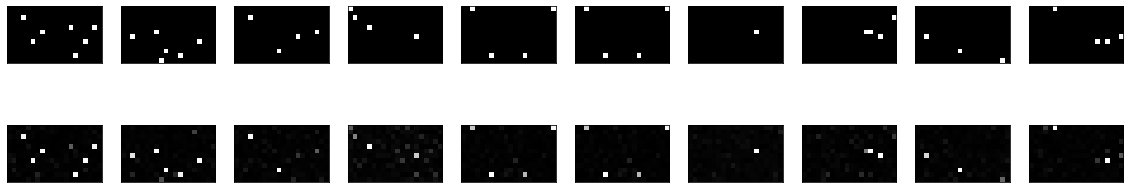

In [390]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_all[i].reshape(12, -1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(12, -1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

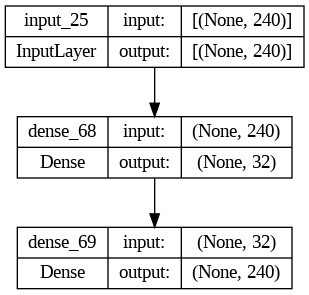

In [391]:
keras.utils.plot_model(autoencoder, show_shapes=True)

In [392]:
print(decoded_imgs[0].max())
print(decoded_imgs[0].min())

0.99558294
0.00016867979


In [393]:
c_model.evaluate(x_all, y_all)

32/32 [==============================] - 0s 2ms/step - loss: 0.5951 - accuracy: 0.8465


[0.5950692892074585, 0.8464606404304504]

In [394]:
c_model.evaluate(decoded_imgs, y_all)

32/32 [==============================] - 0s 1ms/step - loss: 0.9638 - accuracy: 0.6710


[0.963797390460968, 0.6709870100021362]

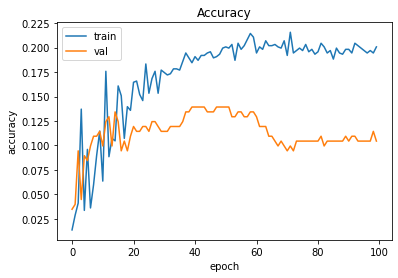

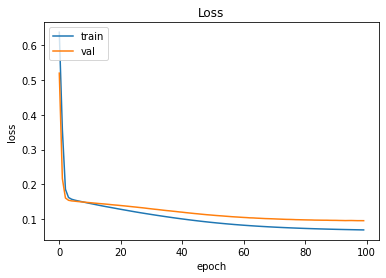

In [395]:
# 10. 학습 시각화하기
import matplotlib.pyplot as plt
n h n
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()